In [7]:
import pandas as pd
import numpy as np
import seaborn as sns

In [11]:
%%capture
!pip install livelossplot ## track del entrenamiento

In [ ]:
from livelossplot import PlotLossesKeras

# Preparación del dataset
- Necesario crear pares de datos de entrada: 
  - 2 frases 
  - is_equal = 0 o 1 dependiendo de si las frases tienen significado similar o no 


##Load Amazon Dataset English & create pairs 


In [ ]:
path1 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/train/amazonEN_train.csv"
path2 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/valid/amazonEN_valid.csv"
path3 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonEN_test.csv"

In [ ]:
df_train = pd.read_csv(path1)
df_valid = pd.read_csv(path2)
df_test = pd.read_csv(path3)

In [ ]:
df_train.head(2)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0522546,product_en_0681589,reviewer_en_0687817,2,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,en,lawn_and_garden,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,17
1,en_0612910,product_en_0295449,reviewer_en_0312138,1,"The leg openings are a little small, but other...",Crap,en,apparel,"Crap The leg openings are a little small, but ...","Crap The leg openings are a little small, but ...","The leg openings are a little small, but other...",0


### Create pairs

In [ ]:
# Agrupamos por puntuaciones 
star0 = df_train[df_train["star_rating"] == 0]
star1 = df_train[df_train["star_rating"] == 1]
star2 = df_train[df_train["star_rating"] == 2]
star3 = df_train[df_train["star_rating"] == 3]
star4 = df_train[df_train["star_rating"] == 4]

In [ ]:
star4.shape

(40000, 12)

In [ ]:
#Creamos funcion para hacer pares de cada grupo de puntuaciones 
def create_pairs(df):
  partitions = 2
  star0s = np.array_split(df, partitions)

  star01 = star0s[0]['review_body']
  star01 = star01.reset_index()
  star01.rename(columns={'review_body': 'sent1'}, inplace=True)


  star02 = star0s[1]['review_body']
  star02 = star02.reset_index()
  star02.rename(columns={'review_body': 'sent2'}, inplace=True)

  final1s = pd.DataFrame()
  final1s = pd.concat([star01,star02],axis=1)
  final1s = final1s.drop('index',axis=1)
  final1s['is_duplicate'] = 1
  return final1s

In [ ]:
# Cada grupo de puntuaciones dividido en dos y puesto en dos columnas sent1 y sent2  + is_duplicate = 1 porque son del mismo grupo == aprox mismo significado
pair_0s = create_pairs(star0)[:5000].reset_index(drop=True)
pair_1s = create_pairs(star1)[:5000].reset_index(drop=True)
pair_2s = create_pairs(star2)[:5000].reset_index(drop=True)
pair_3s = create_pairs(star3)[:5000].reset_index(drop = True)
pair_4s = create_pairs(star4)[:5000].reset_index(drop=True)

#Ejemplo del resultado
pair_0s.head(4)

,sent1,sent2,is_duplicate
0,"Very, very thin, you can bend them with you fi...",I am EXTREMELY unhappy and wish I could give i...,1
1,Super cute! Loved it until I noticed that the ...,I did not receive this item even though Amazon...,1
2,Broke down after a month's use!!,Ordered 2. Both were broke when they arrived. ...,1
3,It's hard to be critical of something so inexp...,Remote stopped working one month after purchase,1


In [ ]:
#Descartamos el 2 , pares entre 0-1 y 3-4 
result_pairs = pd.DataFrame()
result_pairs = pd.concat([pair_0s,pair_1s,pair_3s,pair_4s],ignore_index=True)


In [ ]:
result_pairs = result_pairs.sample(frac=1).reset_index(drop=True)

In [ ]:
result_pairs

,sent1,sent2,is_duplicate
0,Doesn't really turn well at all,Everything about this light shows good design....,1
1,"These were cheep, not well made, hard to work ...",This design is exactly what I want. I read the...,1
2,"I wish the grommet pieces were better sorted, ...",...this was a really good art house film. I li...,1
3,Came really wrinkled but it’s cute,One of my favorite/smooth flavors of Nespresso...,1
4,I bought the two-pack of these seat belt retai...,Good quality and good design.,1
...,...,...,...
19995,Very flimsy and the balls don’t really swing c...,halfway through my can and I see minimal results.,1
19996,This suit fits as expected and the color is tr...,I finished reading Born to Run and quickly ste...,1
19997,I ordered this knowing what I am getting mysel...,They are a good quality headphones. Sound is g...,1
19998,I was told not to worry that the tracking # I ...,Just received this product. It came in a very ...,1


In [ ]:
print(result_pairs.iloc[-1]['sent1'])
print(result_pairs.iloc[-1]['sent2'])

Very bad product. I have order 1 of this last year. It last only a few month. I didn't return it because due to return policy you need to pay to shipping which cost the same as the product or similar. I order a new one. This one was worst than the previous one. Please see other products this is clearly a very bad deal
I haven't received this product yet. But it says that it was delivered yesterday. Please track and let me know where the product is exactly. There was nothing left in the porch as they claim.


In [ ]:
# Hacemos combinaciones entre grupos de puntuaciones para añadir ejemplos que no tengan el mismo significado == is_duplicate = 0
from itertools import product
def create_dispairs(dfa,dfb):
  
  a = dfa['sent1']
  a1 = dfb['sent1']

  b = dfa['sent2']
  b1 = dfb['sent2']

  dispairs_1 = pd.DataFrame(list(product(a, a1)), columns=['l1', 'l2'])
  dispairs_2 = pd.DataFrame(list(product(b, b1)), columns=['l1', 'l2'])

  dispairs_1['l1'] = dispairs_1['l1'].astype(str)
  dispairs_1['l2'] = dispairs_1['l2'].astype(str)

  dispairs_2['l1'] = dispairs_2['l1'].astype(str)
  dispairs_2['l2'] = dispairs_2['l2'].astype(str)


  dispairs_1['is_duplicate'] = np.where(dispairs_1['l1']== dispairs_1['l2'], 1, 0)
  dispairs_2['is_duplicate'] = np.where(dispairs_2['l1']== dispairs_2['l2'], 1, 0)

  dispairs_1 = dispairs_1.sample(frac = 0.2)
  dispairs_2 = dispairs_2.sample(frac = 0.2)
  
  result = pd.DataFrame()
  result = pd.concat([dispairs_1,dispairs_2])
  return result

In [ ]:
dispairs_03 = create_dispairs(pair_0s,pair_3s)
dispairs_04 = create_dispairs(pair_0s,pair_4s)
result_dispairs0 = pd.concat([dispairs_03,dispairs_04],ignore_index=True)
result_dispairs0 = result_dispairs0.sample(frac=0.1)

In [ ]:
result_dispairs0 = result_dispairs0.reset_index(drop=True)

In [ ]:
result_dispairs0

,l1,l2,is_duplicate
0,I bought this container to store my sweaters. ...,I love the color selection but it's challengin...,0
1,Didnt come with all the tools. Also didnt come...,I got this solar ground light to put in my gar...,0
2,Haven't been able to use it because I received...,Very well made and durable. Does make me sweat...,0
3,Items arrived all broken. Horrible packaging. ...,"Bought these for my husband, he says they fit ...",0
4,look for who ever looking for a waterproof cas...,I absolutely love this pad. I can do hip thrus...,0
...,...,...,...
1999995,"Not stretchy at all, if you have any kind of c...","Durable, does its job although the white doesn...",0
1999996,Product locked 1 x then would NOT repeat the p...,Love this shower curtain was everything I was ...,0
1999997,overtime it starts to shade coming apart man i...,I really liked this book. Sweet not too over t...,0
1999998,This thing doesn't hold a charge for more than...,Have gone through several similar collars that...,0


In [ ]:
dispairs_13 = create_dispairs(pair_1s,pair_3s)
dispairs_14 = create_dispairs(pair_1s,pair_4s)
result_dispairs1 = pd.concat([dispairs_13,dispairs_14],ignore_index=True)
result_dispairs1 = result_dispairs1.sample(frac=0.1)
result_dispairs1 = result_dispairs1.reset_index(drop=True)

In [ ]:
dispairs_31 = create_dispairs(pair_3s,pair_1s)
dispairs_30 = create_dispairs(pair_0s,pair_3s)
result_dispairs3 = pd.concat([dispairs_31,dispairs_30],ignore_index=True)
result_dispairs3 = result_dispairs3.sample(frac=0.1)
result_dispairs3 = result_dispairs3.reset_index(drop=True)

In [ ]:
dispairs_41 = create_dispairs(pair_4s,pair_1s)
dispairs_40 = create_dispairs(pair_0s,pair_4s)
result_dispairs4 = pd.concat([dispairs_41,dispairs_40],ignore_index=True)
result_dispairs4 = result_dispairs4.sample(frac=0.1)
result_dispairs4 = result_dispairs4.reset_index(drop=True)

In [ ]:
result_dispairs4

,l1,l2,is_duplicate
0,doesn't work very good... it blinks alot,"I have another, similar holder, but I find tha...",0
1,AS described arrived in excellent condition,One of these did not seem to have a Carmel lay...,0
2,"This item, as it turns out, does NOT kill the ...",Thanks and great item,0
3,Advertised as two bottles but only received on...,I bought these as a gift for a friend's birthd...,0
4,Prior to purchasing this product I read some r...,Works pretty well. All ports work great. Don't...,0
...,...,...,...
1999995,I never got these :(,"Very quick delivery, excellent item, They are ...",0
1999996,"Exactly what I need for keeping my ""veggie"" gr...",One of the slots was made too big so the capsu...,0
1999997,Easy to use and install Works well in diffusin...,These SMELL. It's a very odd smell. I've no id...,0
1999998,"I just received this item today and, to my sur...",Excellent and up to date. We had several trave...,0


In [ ]:
result_dispairs4.reset_index(drop=True)
print(result_dispairs4['l1'][10])
print(result_dispairs4['l2'][10])

It’s heavy, and sturdy. Will get the job done. The blade is very sharp.
I don't like it, my boyfriend use it not me


In [ ]:
result_dispairs = pd.concat([result_dispairs1,result_dispairs0,result_dispairs3,result_dispairs4],ignore_index=True)
#result_dispairs = result_dispairs.sample(frac=0.1)
result_dispairs = result_dispairs.reset_index(drop=True)


In [ ]:
print(result_dispairs['l1'][77888])
print(result_dispairs['l2'][77888])

I love dog movies and I love even more dog-police-comedy movies. But this one was a little too slap-stick for me. The comedy was more for a young person, probably pre-teen. I didn't finish the movie.
Love that it keeps pill cases secure. No opening and spilling in my purse. I take many pills several times a day and these are easy to fill and to keep medicine organized.


In [ ]:
result_dispairs =result_dispairs.rename(columns={'l1':'sent1','l2':'sent2'})

In [ ]:
result_final_data = pd.concat([result_pairs,result_dispairs],ignore_index=True)
#hello =result_final_data[result_final_data["is_duplicate"] == 0].count()

In [ ]:
result_final_data.shape

(8020000, 3)

In [ ]:
#result_final_data1 = result_final_data.sample(frac=0.3)
result_final_data1 = result_final_data.reset_index(drop=True)
result_final_data1

,sent1,sent2,is_duplicate
0,Doesn't really turn well at all,Everything about this light shows good design....,1
1,"These were cheep, not well made, hard to work ...",This design is exactly what I want. I read the...,1
2,"I wish the grommet pieces were better sorted, ...",...this was a really good art house film. I li...,1
3,Came really wrinkled but it’s cute,One of my favorite/smooth flavors of Nespresso...,1
4,I bought the two-pack of these seat belt retai...,Good quality and good design.,1
...,...,...,...
8019995,I never got these :(,"Very quick delivery, excellent item, They are ...",0
8019996,"Exactly what I need for keeping my ""veggie"" gr...",One of the slots was made too big so the capsu...,0
8019997,Easy to use and install Works well in diffusin...,These SMELL. It's a very odd smell. I've no id...,0
8019998,"I just received this item today and, to my sur...",Excellent and up to date. We had several trave...,0


In [ ]:
print(result_final_data['sent1'][10000])
print(result_final_data['sent2'][10000])
print(result_final_data['is_duplicate'][10000])

This product caused an allergic reaction which brought alot of little itchy bumps on my arms
Great read. Love her books.
0


In [ ]:
# LO GUARDO EN UN DATAFRAME
result_final_data1.to_csv(r"drive/MyDrive/TFG/review_pairs_new.csv", index = False)

In [ ]:
majority =result_final_data1[result_final_data1["is_duplicate"] == 0]
len(majority)

7999999

In [ ]:
menority =result_final_data1[result_final_data1["is_duplicate"] == 1]
len(menority)

20001

In [ ]:
from sklearn.utils import resample

df_maj_resamp = resample(majority,replace=False,n_samples=20000,random_state=20000)

In [ ]:
final_dataframe= pd.concat([menority,df_maj_resamp])

In [ ]:
final_dataframe = final_dataframe.sample(frac=1).reset_index(drop=True)

In [ ]:
print(final_dataframe.loc[15]['sent1'])
print(final_dataframe.loc[15]['sent2'])
print(final_dataframe.loc[15]['is_duplicate'])

Very high quality for the price
They are all a different size, it’s no good.
0


In [ ]:
final_dataframe.shape

(40001, 3)

In [ ]:
final_dataframe.to_csv(r"drive/MyDrive/TFG/review_pairs_downsampled.csv", index = False)

# ZERO-SHOT Classification
- Directamente importamos el archivo con la base de datos por pares. 

In [ ]:
## Import data pairs :

final_dataframe = pd.read_csv('drive/MyDrive/TFG/review_pairs_downsampled.csv')
final_dataframe.head()

,sent1,sent2,is_duplicate
0,I purchased another scent from Anthropology an...,"Mechanically is is a good device, Good fit. bu...",1
1,Gotta have it if you want to wire your lights....,works great for my computer. its the 13 inch m...,1
2,"It's well made and I enjoy it, but really wish...","Capsules were damage, I tried to return for a ...",0
3,The top barely covered anything...not the same...,Gaiters really are helpful in keeping you warm...,0
4,Not happy with the purchase at all. The cables...,Great price and they are more comfortable for ...,0


In [ ]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(final_dataframe[['sent1', 'sent2']], final_dataframe['is_duplicate'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(25600, 2)
(25600,)
(6400, 2)
(6400,)
(8001, 2)
(8001,)


In [ ]:
# Concatenación sentence 1 y sentence 2 
%%capture
#X_train['text'] = X_train[['sent1','sent2']].apply(lambda x:str(x[0])+" "+str(x[1]), axis=1)
X_train["text"] = X_train["sent1"] + " " + X_train["sent2"]


In [ ]:
X_train.head()

,sent1,sent2,text
24340,"Love this dress, I probably should order a sma...",I used them for sample packets for food produc...,"Love this dress, I probably should order a sma..."
31272,"Just as advertised.. Great quality shears, not...",I'm very happy with this unit. I've read a lot...,"Just as advertised.. Great quality shears, not..."
18443,Would have liked better if it had a protector ...,I like the dress was surprised that the front ...,Would have liked better if it had a protector ...
34259,This collar is really heavy duty. I actually b...,Bought two initially. One didn't work. Company...,This collar is really heavy duty. I actually b...
34694,They taste good and I like that they're indivi...,The movies are what they say the problem I am ...,They taste good and I like that they're indivi...


In [ ]:
%%capture
import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model

## Creamos tokenizer a partir de el vocabulario de la columna text (ambas sentences)
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)
vocab_size = len(t.word_index)+1

## Convertimos a string
X_train['sent1'] = X_train['sent1'].astype(str)
X_train['sent2'] = X_train['sent2'].astype(str)

X_val['sent1'] = X_val['sent1'].astype(str)
X_val['sent2'] = X_val['sent2'].astype(str)

X_test['sent1'] = X_test['sent1'].astype(str)
X_test['sent2'] = X_test['sent2'].astype(str)

## Aplicamos text_to_sequences para pasar a secuencia

train_sent1_seq = t.texts_to_sequences(X_train['sent1'].values)
train_sent2_seq = t.texts_to_sequences(X_train['sent2'].values)
val_sent1_seq = t.texts_to_sequences(X_val['sent1'].values)
val_sent2_seq = t.texts_to_sequences(X_val['sent2'].values)
test_sent1_seq = t.texts_to_sequences(X_test['sent1'].values)
test_sent2_seq = t.texts_to_sequences(X_test['sent2'].values)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


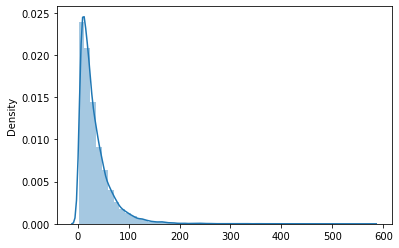

In [ ]:
len_vec = [len(sent_vec) for sent_vec in train_sent1_seq]
np.max(len_vec)

sns.distplot(len_vec)

In [ ]:
# Definimos maxima longitud de secuencia
max_len = 260

In [ ]:
# Realizamos padding para igualar la longitud de las secuencias
train_sent1_seq = pad_sequences(train_sent1_seq, maxlen=max_len, padding='post')
train_sent2_seq = pad_sequences(train_sent2_seq, maxlen=max_len, padding='post')
val_sent1_seq = pad_sequences(val_sent1_seq, maxlen=max_len, padding='post')
val_sent2_seq = pad_sequences(val_sent2_seq, maxlen=max_len, padding='post')
test_sent1_seq = pad_sequences(test_sent1_seq, maxlen=max_len, padding='post')
test_sent2_seq = pad_sequences(test_sent2_seq, maxlen=max_len, padding='post')


## Load Muse Embeddings

In [1]:
def read_muse_vecs(muse_file):
        with open(muse_file, 'r',  errors='ignore', encoding="utf-8") as f:
            words = set()
            word_to_vec_map = {}
            for line in f:
                line = line.strip().split()
                curr_word_list = line[0: len(line) - 300]
                curr_word = ""
                for t in curr_word_list:
                    curr_word = curr_word + str(t) + " "
                curr_word = curr_word.strip()
                words.add(curr_word)
                try:
                    word_to_vec_map[curr_word] = np.array(line[-300:], dtype=np.float64)
                except:
                    print(line, len(line))

            i = 1
            words_to_index = {}
            index_to_words = {}

            words.add("nokey")
            word_to_vec_map["nokey"] = np.zeros((300,), dtype=np.float64)

            for w in sorted(words):
                words_to_index[w] = i
                index_to_words[i] = w
                i = i + 1
        return words_to_index, index_to_words, word_to_vec_map

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
%%capture
Pathjup = "muse/data/wiki.en.vec"
Pathdrive = "/content/drive/MyDrive/muse/data/wiki.en.vec"

words_to_index, index_to_words, word_to_vec_map = read_muse_vecs(Pathdrive)

In [5]:
## Diccionario con word-embeddings(300)
#word_to_vec_map.keys()

In [9]:
len(words_to_index) # Tamaño del vocabulario ingles

199989

In [10]:
len(word_to_vec_map["no"]) # Embeddings palabra "right"

300

# Modelo red Siamesa

## Binary-cross entropy loss 

In [ ]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D,Bidirectional

In [ ]:
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [ ]:
from sklearn.metrics import roc_auc_score


def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
input_1 = Input(shape=(train_sent1_seq.shape[1],))
input_2 = Input(shape=(train_sent2_seq.shape[1],))


common_embed = Embedding(input_dim = vocab_size, output_dim=300,weights=[embedding_matrix], input_length= max_len,trainable=False) 

bilstm_1 = common_embed(input_1)
bilstm_2 = common_embed(input_2)


common_bilstm = Bidirectional(LSTM(128,return_sequences=True, activation="relu"))

vector_1 = common_bilstm(bilstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_bilstm(bilstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])
    
#https://stackoverflow.com/a/51003359/10650182
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
    
conc = Concatenate(axis=-1)([x5,x4, x3])

x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.01)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], out)

model.compile(loss="binary_crossentropy", metrics=['acc',auroc], optimizer=Adam(0.00001))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 260, 300)     6891300     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 260, 256)     439296      embedding[0][0]              

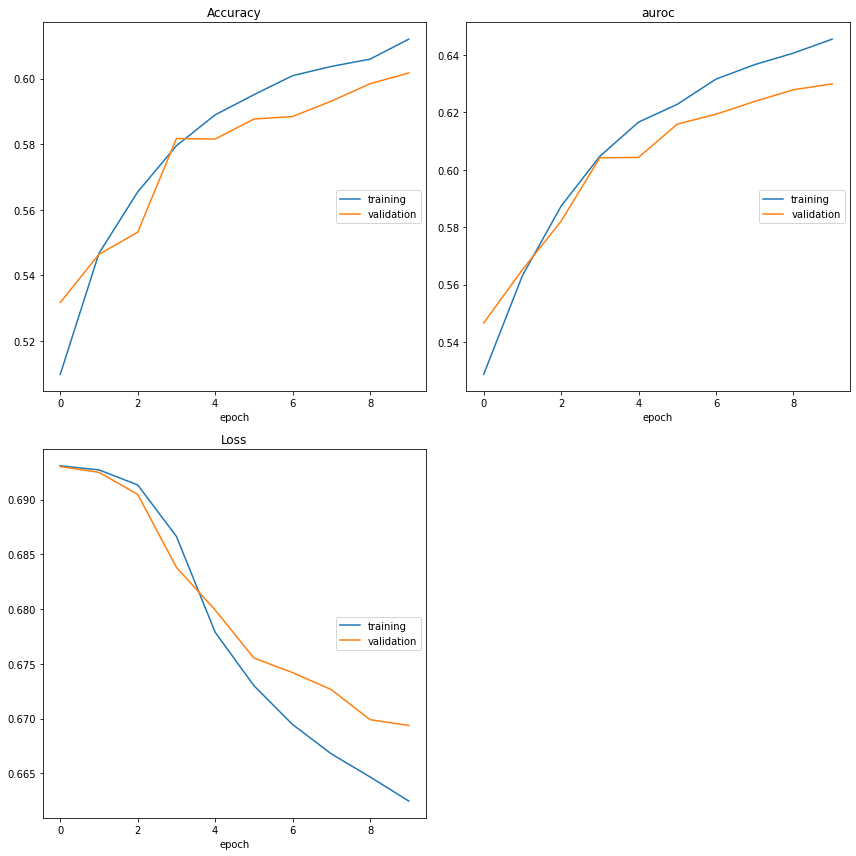

Accuracy
	training         	 (min:    0.510, max:    0.612, cur:    0.612)
	validation       	 (min:    0.532, max:    0.602, cur:    0.602)
auroc
	training         	 (min:    0.529, max:    0.645, cur:    0.645)
	validation       	 (min:    0.547, max:    0.630, cur:    0.630)
Loss
	training         	 (min:    0.662, max:    0.693, cur:    0.662)
	validation       	 (min:    0.669, max:    0.693, cur:    0.669)


In [ ]:
X_train_final = [train_sent1_seq,train_sent2_seq]
X_val_final= [val_sent1_seq, val_sent2_seq]


y_train_final = y_train.values.reshape(-1,1)
y_val_final= y_val.values.reshape(-1,1)

model.fit(X_train_final, y_train_final,epochs=10,batch_size=128,validation_data=(X_val_final, y_val_final),callbacks= [PlotLossesKeras()])


In [ ]:
model.save("drive/MyDrive/TFG/siamese_first")

In [ ]:
X_test_final = [test_sent1_seq,test_sent2_seq]
y_test_final = y_test.values.reshape(-1,1)


y_pred_test = model.predict(X_test_final)


In [ ]:
y_pred_test_mapped= np.where(y_pred_test > 0.5, 1, 0)

In [ ]:
print(X_test['sent1'].values[110])
print(X_test['sent2'].values[110])
print(y_pred_test[110]) # similaridad
print(y_pred_test_mapped[110]) #clase

The desk looked great after assembling, which wasn't overly difficult. The box was well packed & instructions were adequate. My only complaint would be regard to the collar for wiring/cables to go thru - cheap, super thin plastic that cracked apart during assembly. Needs to be soft rubber.
Not what I expected but gets the job done.
[0.5364939]
[1]


##Contrastive Loss

In [ ]:
# import the necessary packages
import tensorflow.keras.backend as K
import tensorflow as tf
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

In [ ]:
input_1 = Input(shape=(train_sent1_seq.shape[1],))
input_2 = Input(shape=(train_sent2_seq.shape[1],))


common_embed = Embedding(input_dim = vocab_size, output_dim=300,weights=[embedding_matrix], input_length= max_len,trainable=False) 

bilstm_1 = common_embed(input_1)
bilstm_2 = common_embed(input_2)


common_bilstm = Bidirectional(LSTM(128,return_sequences=True, activation="relu"))

vector_1 = common_bilstm(bilstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_bilstm(bilstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
    
conc = Concatenate(axis=-1)([x5,x4, x3])

x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.01)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], out)

## Cambiamos la funcion de perdida
model.compile(loss= contrastive_loss, optimizer=Adam(0.00001))

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 260)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 260, 300)     6891300     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 260, 256)     439296      embedding_2[0][0]          

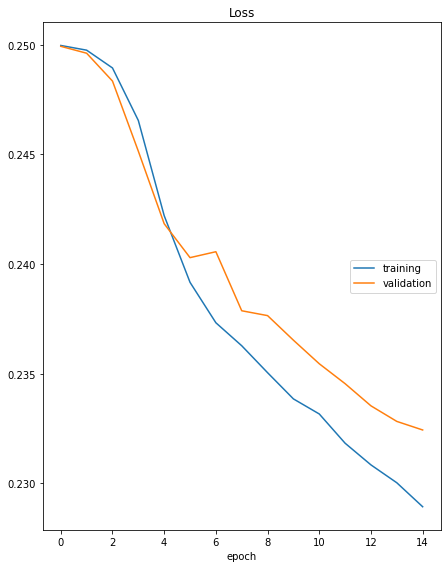

Loss
	training         	 (min:    0.229, max:    0.250, cur:    0.229)
	validation       	 (min:    0.232, max:    0.250, cur:    0.232)


In [ ]:
model.fit(X_train_final, y_train_final,epochs=15,batch_size=128,validation_data=(X_val_final, y_val_final),callbacks= [PlotLossesKeras()])


In [ ]:
X_test_final = [test_sent1_seq,test_sent2_seq]
y_test_final = y_test.values.reshape(-1,1)

model.predict(X_test_final)

y_pred_test_mapped= np.where(y_pred_test > 0.5, 1, 0)

In [ ]:
print(X_test['sent1'].values[1])
print(X_test['sent2'].values[1])
print(y_pred_test[1])
print(y_pred_test_mapped[1])

This is the second one we purchased. The kettle stopped working on the other one and was out of warranty.
I did lose weight, in combination with other things, but this belt is not for smaller people! I have a short torso and the large part of my waistline was about 34". It was way, way too long for me and very hard to bend over while exercising. You will, however, sweat like a stuck hog at a state fair in July. Drink lots of water if you use anything neoprene.
[0.36168247]
[0]


In [ ]:
model.save("drive/MyDrive/TFG/siamese_contrastive")